In [10]:
"""
Script to test loading an efr file in python and run the em_offset.py function on it to 
do the 50s fitting

"""


from scipy.io import loadmat
from scipy import signal
import numpy as np
import time
import pyIGRF
import datetime
import pandas as pd
import matplotlib.pyplot as plt
#from wavesim1d import *
from em_apex_processing import *
from spectral_processing import *
import os
import warnings


#import em_offset

#Load test file
#fname="/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/test_efr/ema-6667i-0003-efr.mat"


#########################
#####Define Constants####
#########################
Cmax=25
uVpc = 1e6 * (10e-3 / (2**24))

Nfit=2
nstep_off=25
navg_off=50
base_fr=0.02

ch=0.06
cz=0.09

nstep = 60 # I think this is the overlap?
#Andy sets navg (spectrum time windowing) to 120
navg = 120 #What is navg? I think this is the number of samples per window
Zmax=100
Dirmax=80
#electrode separation
esep1 = (8+5/8)*0.0254 # m
esep2 = (8+5/8)*0.0254 # m
c1 = 0.5
c2 = -0.2
# angles between compass and electrode axes
alpha2 = 1.95
alpha1 = alpha2 - np.pi/2

###########################


### Load Files ###
fname_base = "/Volumes/TFO-5TB-3/TFO/LCDRI/raw_data/"
save_dir = "/Volumes/TFO-5TB-3/TFO/LCDRI/processed_data/James_output/Spectra/"
float_list = os.listdir(fname_base)


#float_list = ['6667i']
#Loop through every float_id
big_spec_store = [];
big_time_store = [];
big_up_down_store = []
float_id_counter = 0
ignore_count = 0
too_deep_counter = 0
min_bin = []
for float_id in float_list:
    
    if "grid" in float_id:
        continue
        
    dec_name = fname_base+float_id+"/dec/"
    
    #Loop through each profile for that float
    files = os.listdir(dec_name)
    efr_files = [file for file in files if "efr.mat" in file and not file.startswith('.')]
    
    spec_store = np.zeros((len(efr_files), 2, 59))
    time_store = np.zeros(len(efr_files))
    up_down_store = np.zeros(len(efr_files))
    counter=0
    #Load each profiling file, and then calculate the 1D spectrum
    for file in efr_files:
        fname = dec_name + file
        EFR = loadmat(fname)

        
        prof_num = int(file.split('-')[2])
        #Load the UXT times, and correct
        
        efr_times = EFR['UXT'] - EFR['AGE']
        efr_times = efr_times[0, :]
        seqno = EFR['SEQNO'][0, :]
        
        #Fit UXT times to sequence number (measurement # for that profile) to make sure monotonically increasing
        p = np.polyfit(seqno,efr_times,1)
        pfit = np.poly1d(p)
        mlt_efr = pfit(seqno);

        
        #Load GPS file for calculating 
        # gps files are only on up profiles (even)
        if prof_num%2==0:
            cut = fname.find("efr")
            gpsfname = fname[:cut]+"gps.mat"
        else:
            new_file = file.split('-')[0]+'-'+file.split('-')[1]+'-{:04d}'.format(prof_num+1)+'-gps.mat'
            gpsfname = dec_name+new_file
        GPS = loadmat(gpsfname)

        #Load CTD file 
        cut = fname.find("efr")
        ctdfname = fname[:cut]+"ctd.mat"
        CTD = loadmat(ctdfname)
        
        ctd_time = CTD["UXT"][0, :]
        P = CTD["P"][0, :]
        Pef = np.interp(mlt_efr, ctd_time, P)

        tim_pd = pd.to_datetime(GPS["UXT_GPS"][0, :],unit='s', utc=True,)
        #Convert time to fractional year for use in the igrf function
        frac_yrs = np.array([year_fraction(dt) for dt in tim_pd])
        avg_lat = np.nanmean(GPS["LAT"][0, :])
        avg_lon = np.nanmean(GPS["LON"][0, :])
        avg_frac_yrs = np.nanmean(frac_yrs)

        #Get magnetic field values
        [Bx, By, Bz, f] = pyIGRF.calculate.igrf12syn(avg_frac_yrs, 1, 0, avg_lat, avg_lon)

        
        fz=-np.nanmean(Bz);
        fh=np.nanmean(np.sqrt(Bx**2+By**2));
        sfv1 = 1e3/(fz*esep1*(1.0+c1));
        sfv2 = 1e3/(fz*esep2*(1.0+c1));
        
        #Convert from counts to microvolts
        E1 = (EFR["E1"][0, :]-2**23) * uVpc;
        E2 = (EFR["E2"][0, :]-2**23) * uVpc;
        
        #pull out compass values
        HZ = EFR["HZ"][0, :];
        HY = EFR["HY"][0, :];
        HX = EFR["HX"][0, :];
        
        #Do the 50s fits 
        [e1offs,e2offs,e1fits,e2fits,anghxhy] = em_offset(Nfit,mlt_efr,nstep_off,navg_off,E1,E2,HX,HY);

        #Get overall fi and calculate the residuals
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            e1off=np.nanmean(e1offs,1);
            e2off=np.nanmean(e2offs,1);
            e1fit=np.nanmean(e1fits,1);
            e2fit=np.nanmean(e2fits,1);

        #Calculate the residual
        e1r = E1 - e1fit
        e2r = E2 - e2fit

        #Now need to convert to velocity (m/s)
        e1r = e1r*sfv1
        e2r = e2r*sfv2
        

        #Now use the angles to rotate to x-y coordinates
        avg_angs = np.copy(anghxhy)
        avg_angs[~np.isnan(avg_angs)] = np.unwrap(avg_angs[~np.isnan(avg_angs)])
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            avg_angs = np.nanmean(avg_angs, axis=1)


        E2_r=e2r*np.cos(avg_angs)+e1r*np.sin(avg_angs);
        E1_r=-e2r*np.sin(avg_angs)+e1r*np.cos(avg_angs);

        E_x = E1_r
        E_y = E2_r
        
        #Now try highpass filtering the data
        sos = signal.butter(10, 0.04, 'hp', fs=1, output='sos')
        E_x_filtered = signal.sosfilt(sos, E_x)
        E_y_filtered = signal.sosfilt(sos, E_y)
        
        E_x = E_x_filtered
        E_y = E_y_filtered
        
        
        #Now take the spectra
        nblock = 120
        fs = 1
        overlap = 60
        #[u_x, t_new] = reshape_u(E_x, mlt_efr, nblock, overlap, fs)

        [u_x, z_x] = reshape_u(E_x, Pef, nblock, overlap, fs)
        
        #prof_speed is a numpy array that stores the mean vertical velocity (in m/s)
        #for each spectral window
        #prof_speed = np.abs(z_x[:, 0]-z_x[:, -1])/np.abs(t_new[:, 0]-t_new[:, -1])
        
        UUwindow, fwindow = make_vel_spectrum(u_x, fs)

        [u_y, z_y] = reshape_u(E_y, Pef, nblock, overlap, fs)

        VVwindow, fwindow = make_vel_spectrum(u_y, fs)

        min_z = np.min(Pef)
        min_bin = np.append(min_bin, min_z)
        if min_z>20:
            too_deep_counter+=1
        else:  
        
            UU = UUwindow/(int(nblock/2)*fs)
            Exx = UU[:,1:]/ (np.square((2*np.pi*fwindow[1:])))
            VV = UUwindow/(int(nblock/2)*fs)
            Eyy = VV[:,1:]/ (np.square((2*np.pi*fwindow[1:])))

            Eh = Exx+Eyy

            [Eh_Eric1, Eh_Eric2, Eh_Eric3, Eh_Eric4] = depth_correct_Eric(Eh, fwindow[1:], z_x, nblock, Cmax, fs)
            #Average each profile spec and add to the storer
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                spec_store[counter, 0, :] = np.nanmean(Eh, axis=0)
                spec_store[counter, 1, :] = np.nanmean(Eh_Eric4, axis=0)
                time_store[counter] = np.nanmean(mlt_efr)
                if prof_num%2==0:
                    #Then it's even and its an up profile
                    up_down_store[counter] = 1
                else:
                    up_down_store[counter] = 0

        
        
            counter+=1
        
    if float_id_counter==0:
        big_spec_store=spec_store
        big_time_store = time_store
        big_up_down_store = up_down_store
    else:
        big_spec_store = np.append(big_spec_store, spec_store, axis=0)
        big_time_store = np.append(big_time_store, time_store)
        big_up_down_store = np.append(big_up_down_store, up_down_store)


    
    float_id_counter+=1
        
    #np.save(save_dir+float_id, spec_store)

    
#out = zip(blah2, blah)
#blah3 = sorted(out, key=lambda tup: tup[1])

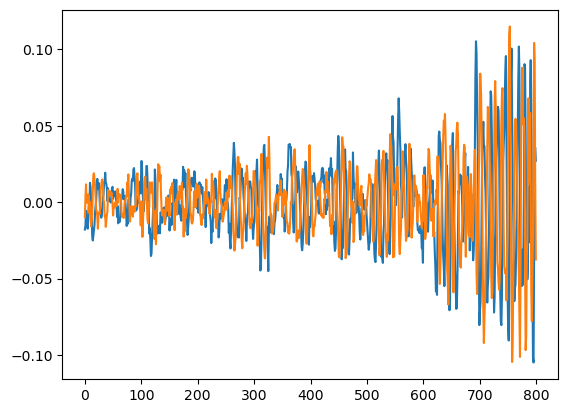

In [2]:
plt.plot(E1_r)
plt.plot(E_x_filtered)

14.845760746594957

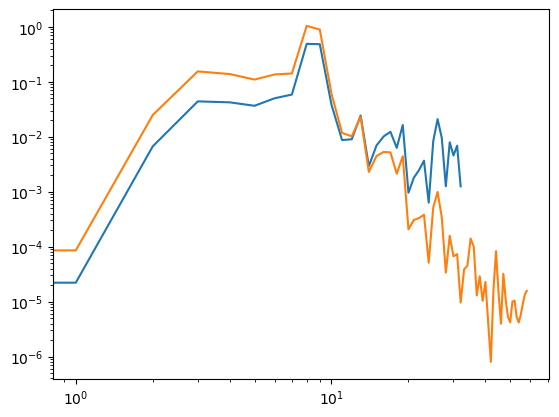

In [12]:
plt.loglog(Eh_Eric4[-1, :])
plt.loglog(Eh[-1, :])
np.nanmean(z_x[-1, :])


In [4]:
k_array = np.sqrt(2*np.pi*fwindow/9.8);
k_array2 = np.square(2*np.pi*fwindow/9.8)
print(k_array)
print(k_array2)

[0.         0.07309476 0.10337161 0.12660385 0.14618953 0.16344486
 0.17904488 0.19339057 0.20674322 0.21928429 0.23114594 0.24242791
 0.25320769 0.26354692 0.27349557 0.28309481 0.29237906 0.30137744
 0.31011482 0.31861269 0.32688973 0.33496229 0.34284484 0.35055018
 0.35808975 0.36547382 0.37271163 0.37981154 0.38678114 0.39362736
 0.40035652 0.40697443 0.41348643 0.41989746 0.42621206 0.43243446
 0.43856859 0.4446181  0.45058639 0.45647666 0.46229188 0.46803486
 0.47370822 0.47931443 0.48485582 0.49033459 0.49575282 0.50111246
 0.50641539 0.51166335 0.51685804 0.52200103 0.52709385 0.53213792
 0.53713463 0.54208528 0.54699113 0.55185337 0.55667314 0.56145154]
[0.00000000e+00 2.85459889e-05 1.14183956e-04 2.56913900e-04
 4.56735823e-04 7.13649724e-04 1.02765560e-03 1.39875346e-03
 1.82694329e-03 2.31222510e-03 2.85459889e-03 3.45406466e-03
 4.11062241e-03 4.82427213e-03 5.59501383e-03 6.42284751e-03
 7.30777317e-03 8.24979080e-03 9.24890042e-03 1.03051020e-02
 1.14183956e-02 1.258878

In [13]:
#Try loading them all at once and then putting them together in a bigass array and then sorting...

#But first wemwould need to save the times


out = zip(big_spec_store, big_time_store)
#list(out)[0]
sorted_array = sorted(out, key=lambda tup: tup[1])

unzipped = ([ a for a,b in sorted_array ], [ b for a,b in sorted_array ])

spec_store_sorted = np.array(unzipped[0])
time_store_sorted = np.array(unzipped[1])

kill = np.where(spec_store_sorted[:, 0, 5]==0)
#spec_stor
time_store_sorted = time_store_sorted[kill[0][-1]+1:]
spec_store_sorted = spec_store_sorted[kill[0][-1]+1:, :, :]

(59, 155)
(59, 155)


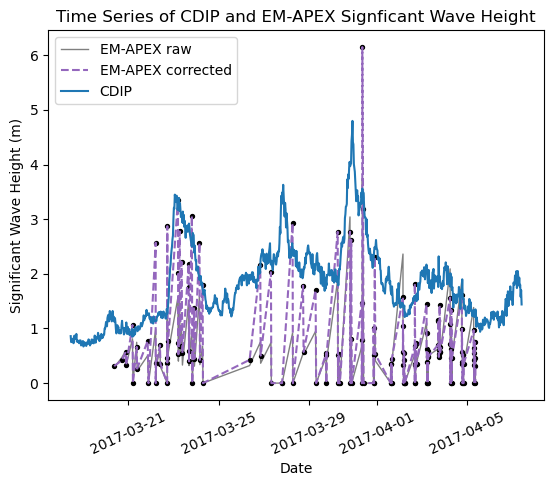

In [14]:
spec_store_sorted_new_raw = spec_store_sorted[:, 0, :]
spec_store_sorted_new_corr = spec_store_sorted[:, 1, :]
sig_wave_array = [];

Hs = sig_wave_height(fwindow, np.transpose(spec_store_sorted_new_raw))
Hs_corr = sig_wave_height(fwindow, np.transpose(spec_store_sorted_new_corr))

t_apex = [datetime.datetime.fromtimestamp(t) for t in time_store_sorted]



plt.plot(t_apex, Hs, color='k', linewidth=1, alpha=0.5, label='EM-APEX raw')
plt.scatter(t_apex, Hs_corr, color='k', s=8)
plt.plot(t_apex, Hs_corr, '--C4', label='EM-APEX corrected')
from scipy.io import netcdf


fname = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/229p1_d01.nc"

nc = netcdf.NetCDFFile(fname, 'r', mmap=False) #Not sure why I need to do mmap = False but it gets rid of a warning
times = nc.variables['waveTime'][:]
ts = [datetime.datetime.fromtimestamp(t) for t in times]
Hs_cdip = nc.variables['waveHs'][:]
energy_density = nc.variables['waveEnergyDensity'][:]
wave_freq = nc.variables['waveFrequency'][:]
#dtimes = datetime(time, 'convertfrom', 'posixtime');
nc.close()
plt.plot(ts, Hs_cdip, label='CDIP')
plt.ylabel("Significant Wave Height (m)")
plt.xlabel('Date')
plt.xticks( rotation=25 )
plt.title("Time Series of CDIP and EM-APEX Signficant Wave Height")
plt.legend()

#plt.savefig("/Users/jamesstadler/Documents/UW/TFO/Figures/LCDRI/CDIP_EM_Hs_Timeseries.png", bbox_inches='tight')

#Maybe try to match these up and scattter plot CDIP vs. Hs

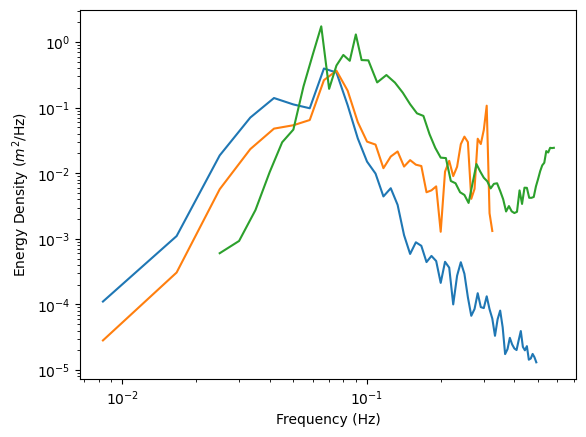

In [18]:
ind = 152
plt.loglog(fwindow[1:], spec_store_sorted_new_raw[ind, :])
plt.loglog(fwindow[1:], spec_store_sorted_new_corr[ind, :])
plt.xlabel("Frequency (Hz)")
plt.ylabel(r"Energy Density ($m^2$/Hz)")
#plt.loglog(np.log(fwindow[1:]), p(np.log(fwindow[1:])))
#a = np.exp(fit[1])
b = -2#fit[0]
a = spec_store_sorted_new_raw[ind, 0]/np.exp(b * np.log(fwindow[1]))
y_fitted = a * np.exp(b * np.log(fwindow[1:]))

#plt.loglog(fwindow[1:], y_fitted)
#plt.loglog(fwindow[1:], spec_store_sorted_new_raw[-4, :]-y_fitted)
ind2 = np.where(np.abs(time_store_sorted[5]-time)==np.min(np.abs(time_store_sorted[5]-time)))
plt.loglog(wave_freq, energy_density[ind2[0][0], :])

In [ ]:
ind

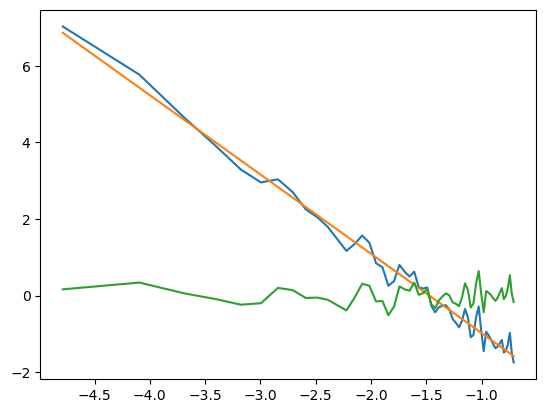

In [5]:
 
num_samples = 1000
rand_samples = 1*np.random.normal(loc = 0, scale = 1, size = num_samples)


[u, z]=reshape_u(rand_samples, np.ones(1000), 120, 60, 1)

[UUwindow_blah, fwindow] = make_vel_spectrum(u, 1)
#Plot spectra of u_noise
#plt.plot(rand_samples)


UU_blah = UUwindow_blah/(int(60)*fs)
Exx_blah = UU_blah[:,1:]/ (np.square((2*np.pi*fwindow[1:])))

#plt.loglog(fwindow[1:], np.nanmean(Exx_blah, axis=0))
fit = np.polyfit(np.log(fwindow[1:]), np.log(np.nanmean(Exx_blah, axis=0)), 1)
p = np.poly1d(fit)

plt.plot(np.log(fwindow[1:]), np.log(np.nanmean(Exx_blah, axis=0)))
plt.plot(np.log(fwindow[1:]), p(np.log(fwindow[1:])))
plt.plot(np.log(fwindow[1:]), np.log(np.nanmean(Exx_blah, axis=0))-p(np.log(fwindow[1:])))
#Do ensemble mean and then get PSD
 #UU = np.nanmean(np.nanmean(UUwindow, axis=1), axis=0)/(int(w/2)*fs)

In [ ]:
np.nanmean(z_x, axis=1)

In [ ]:
spec_store_sorted_new_corr[11, :]

In [ ]:

e1off=np.nanmean(e1offs,1);
e2off=np.nanmean(e2offs,1);
e1fit=np.nanmean(e1fits,1);
e2fit=np.nanmean(e2fits,1);

#Calculate the residual
e1r = E1 - e1fit
e2r = E2 - e2fit

#Now need to convert to voltage
e1r = e1r*sfv1
e2r = e2r*sfv2

#Now use the angles
avg_angs = np.copy(anghxhy)
avg_angs[~np.isnan(avg_angs)] = np.unwrap(avg_angs[~np.isnan(avg_angs)])
avg_angs = np.nanmean(avg_angs, axis=1)


E2_r=e2r*np.cos(avg_angs)+e1r*np.sin(avg_angs);
E1_r=-e2r*np.sin(avg_angs)+e1r*np.cos(avg_angs);

E_x = E1_r
E_y = E2_r


In [ ]:
nblock = 120
fs = 1
[u_x, z_x] = reshape_u(E_x, Pef, nblock, 60, fs)

UUwindow, fwindow = make_vel_spectrum(u_x, fs)
#len(E_x.shape)
[u_y, z_y] = reshape_u(E_y, Pef, nblock, 60, fs)

VVwindow, fwindow = make_vel_spectrum(u_y, fs)




UU = np.nanmean(UUwindow, axis=0)/(int(nblock/2)*fs)
#UU_noise = np.nanmean(np.nanmean(UUwindow_noise, axis=0), axis=0)/(int(w/2)*fs)
Exx = UU[1:]/ (np.square((2*np.pi*fwindow[1:])))
VV = np.nanmean(UUwindow, axis=0)/(int(nblock/2)*fs)
Eyy = VV[1:]/ (np.square((2*np.pi*fwindow[1:])))



In [ ]:
plt.figure()
plt.plot(e1fit)
plt.plot(E1)
plt.figure()
plt.plot(E_x)
plt.plot(E_y)

In [16]:
from scipy.io import netcdf


fname = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/229p1_d01.nc"

nc = netcdf.NetCDFFile(fname, 'r', mmap=False) #Not sure why I need to do mmap = False but it gets rid of a warning
time = nc.variables['waveTime'][:]
Hs = nc.variables['waveHs'][:]
energy_density = nc.variables['waveEnergyDensity'][:]
wave_freq = nc.variables['waveFrequency'][:]
#dtimes = datetime(time, 'convertfrom', 'posixtime');
nc.close()

In [ ]:
energy_density.shape

In [ ]:
datetime.datetime.fromtimestamp(time[541])

In [ ]:

plt.loglog(fwindow[1:], 2*(Eyy+Exx))
plt.loglog(wave_freq, energy_density[541])

In [ ]:
EsMatlab = loadmat("/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/save_tseries.mat")
E1_mat = EsMatlab["E1r"]
E2_mat = EsMatlab["E2r"]

fitsMat = loadmat("/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/save_fits.mat")
plt.plot(e1fit)
plt.plot(np.nanmean(fitsMat["e1fits"], 1))


plt.figure()
#plt.plot(e2fit)
plt.plot(np.nanmean(fitsMat["e2fits"], 1))


plt.figure()
plt.plot(e1fit-np.nanmean(fitsMat["e1fits"], 1))


plt.figure()
plt.plot(EsMatlab["E1"])
plt.plot(E1)

plt.figure()
plt.plot(E1-e1fit)
plt.plot(np.transpose(EsMatlab["E1"]-np.nanmean(fitsMat["e1fits"], 1)))

plt.figure()
plt.plot(E2-e2fit)
plt.plot(np.transpose(EsMatlab["E2"]-np.nanmean(fitsMat["e2fits"], 1)))

In [ ]:
plt.figure()
#plt.plot(EsMatlab["E1"])
#plt.plot(E1)
#plt.plot(np.nanmean(fitsMat["e2fits"], 1))
plt.plot(np.transpose(EsMatlab["E2"]))
plt.plot(E2)
#plt.plot(e2fit)


In [ ]:
plt.plot(E_x, label="py")
plt.plot(E1_mat, label="Mat")
plt.legend()
plt.plot(E_y)

In [ ]:
import os

fname_base = "/Volumes/TFO-5TB-3/TFO/LCDRI/raw_data/"

print(os.listdir(fname_base))
name = '6667i'

In [ ]:
dec_name = fname_base+name+"/dec/"
files = os.listdir(dec_name)
efrs = [file for file in files if "efr.mat" in file and not file.startswith('.')]

In [ ]:
efrs

In [ ]:
int(efrs[1].split('-')[2])

In [ ]:
cut = efrs[2].find("-efr")
print(efrs[2][:cut]+"-gps.mat")

In [ ]:
temp_name = efrs[1]

In [ ]:
temp_name.split('-')[0]+'-'+temp_name.split('-')[1]

In [ ]:
prof_num= int(temp_name.split('-')[2])

In [ ]:
new = temp_name.split('-')[0]+'-'+temp_name.split('-')[1]+'-{:04d}'.format(prof_num+1)+'-gps.mat'

In [ ]:
new

In [ ]:
'Hello-{:04d}'.format(prof_num+1)

In [ ]:
float_list